# UNO Card Game Simulator

This is the steering console where simulations of the UNO card game can be executed. There are two different Reinforcement Learning Models implemented, which can be selected together with their respective model parameters.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Run" data-toc-modified-id="Run-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Run</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><span><a href="#Win-Rate" data-toc-modified-id="Win-Rate-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Win Rate</a></span></li><li><span><a href="#Q-Values" data-toc-modified-id="Q-Values-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Q-Values</a></span></li><li><span><a href="#Visits" data-toc-modified-id="Visits-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Visits</a></span></li><li><span><a href="#Possible-Moves" data-toc-modified-id="Possible-Moves-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Possible Moves</a></span></li></ul></li><li><span><a href="#Extraction" data-toc-modified-id="Extraction-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Extraction</a></span></li></ul></div>

### Import
***

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

sns.set()

In [9]:
def bold(string):
    chr_start = "\033[1m"
    chr_end = "\033[0m"
    print (chr_start + string + chr_end)
    
def underline(string):
    chr_start = "\033[4m"
    chr_end = "\033[0m"
    print(chr_start + string + chr_end)

In [10]:
def color_lib(categories):
    """
    This function generates a dictionary that assigns a specific color from a color spectrum to each fund.
    It enables consistent coloring across visualizations.
    """
    
    c_scale = cm.rainbow(np.linspace(0,1,len(categories)))
    c_dict = {}

    for i,c in zip(categories,c_scale):
        c_dict[i] = c
        
    return c_dict

### Analysis
***

In [11]:
df = pd.read_csv(r"C:\Users\sabri\CodingProjects\4511UNO_SIM\assets\exploration-results.csv")
df.head()

,winner,turns,win_rate
0,AI,27,1.000000
1,Human,71,0.500000
2,AI,21,0.666667
3,Human,95,0.500000
4,Human,42,0.400000


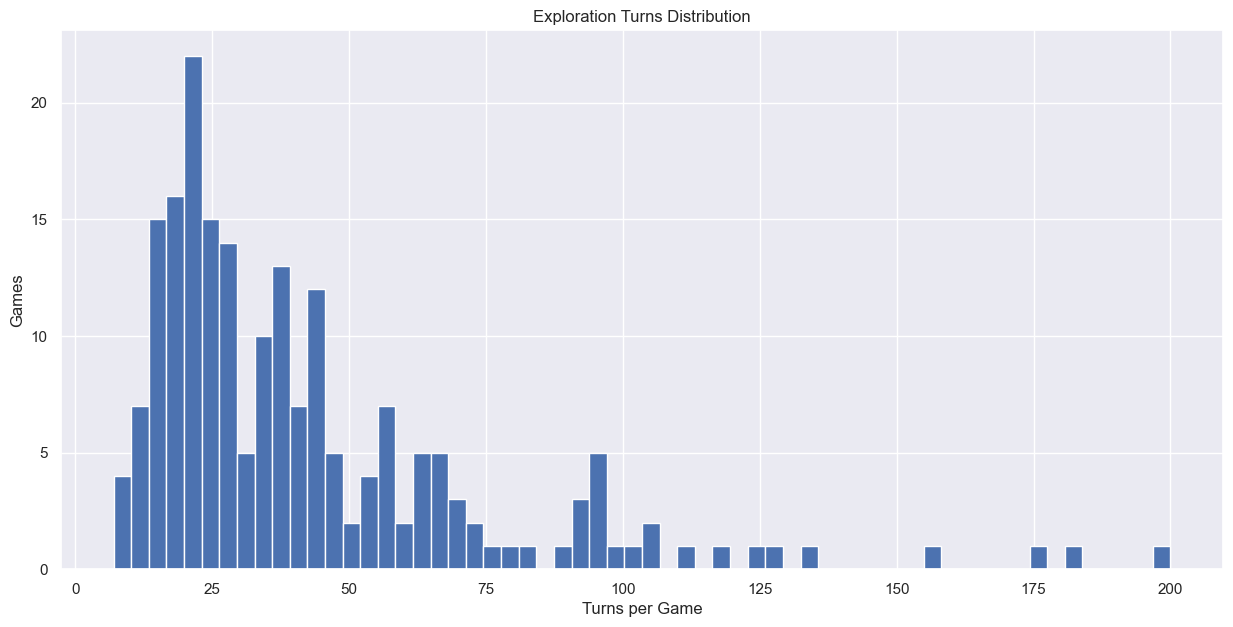

In [12]:
fig = plt.figure(1, figsize=(15,7))

plt.hist(df["turns"], bins =60, edgecolor = "w")
plt.title("Exploration Turns Distribution")
plt.xlabel("Turns per Game")
plt.ylabel("Games")

plt.show()

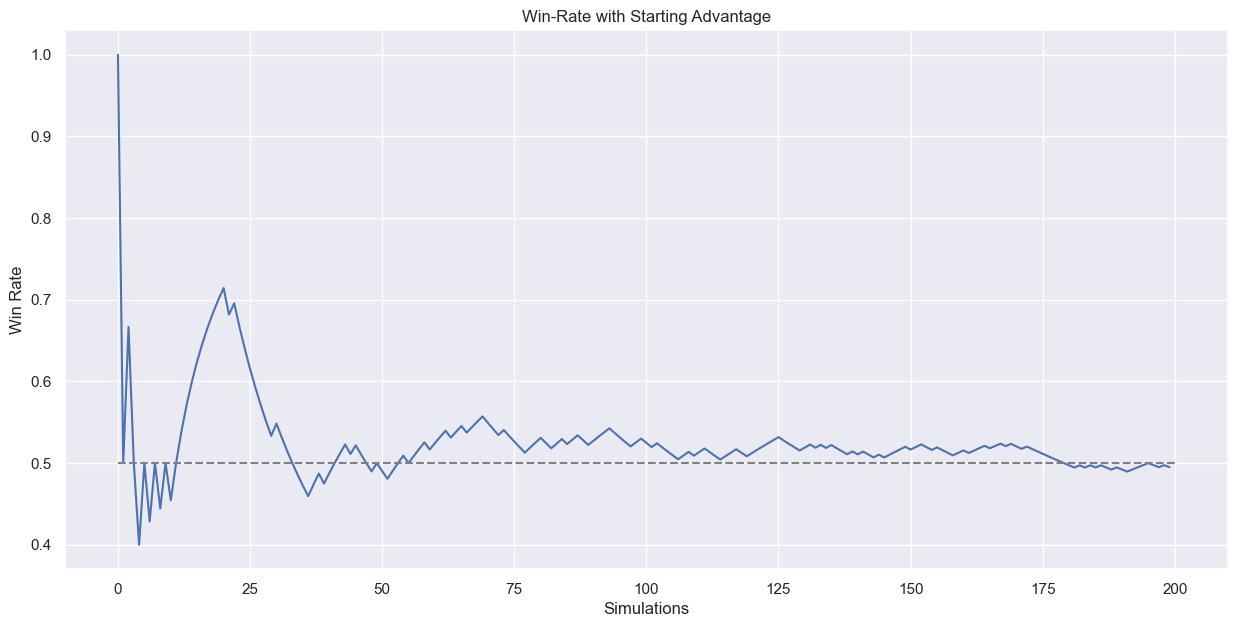

In [13]:
fig = plt.figure(1, figsize=(15,7))

plt.plot(df.index, df["win_rate"])
plt.hlines(0.5, 0, len(df), colors="grey", linestyles="dashed")

plt.title("Win-Rate with Starting Advantage")
plt.xlabel("Simulations")
plt.ylabel("Win Rate")
plt.show()

#### Q-Values

In [14]:
q_values = pd.read_csv('../assets/exploration-q-values.csv',index_col='id')

actions = q_values.columns

q_values['MAX'] = q_values.max(axis=1)
q_values['ID'] = q_values.index
q_values['HAND'] = q_values['ID'].apply(lambda x: sum(eval(x)[1:]))

q_values.drop(columns='ID', inplace=True)
q_values.head(3)

,RED,GRE,BLU,YEL,SKI,REV,PL2,PL4,COL,MAX,HAND
id,,,,,,,,,,,
"('RED', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
"('RED', 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
"('RED', 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.2,1


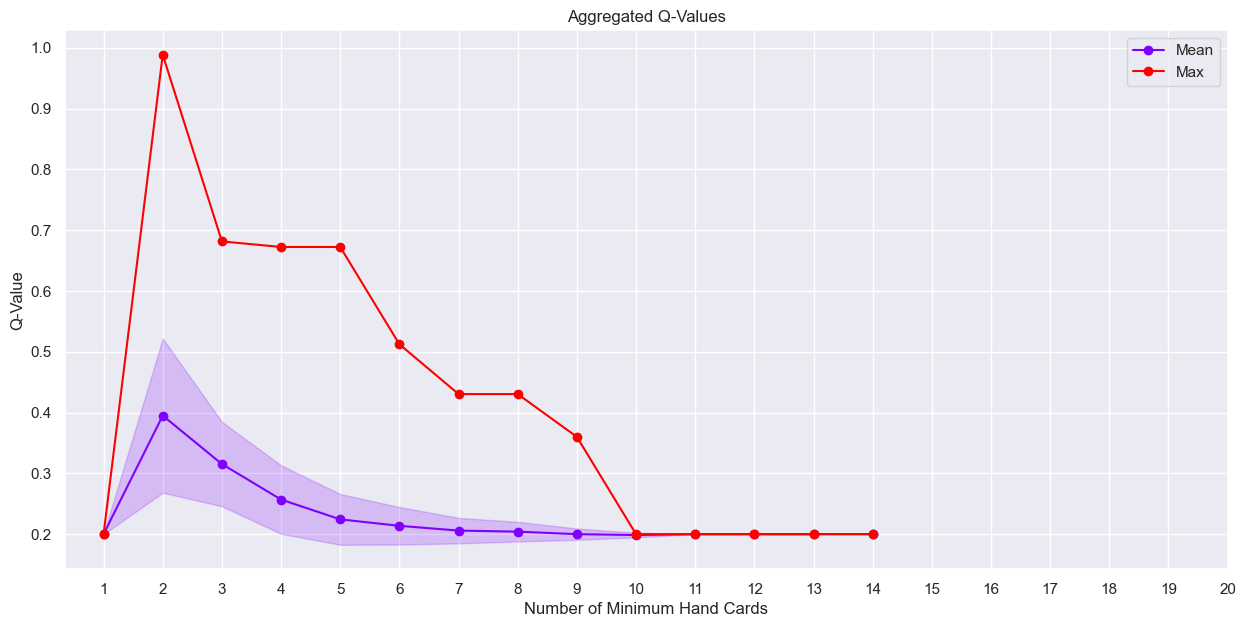

In [15]:
q_curve = q_values.copy()
q_curve[["HAND","MAX"]] = q_curve[["HAND","MAX"]].replace(0, np.NaN)

q_mean = pd.Series(q_curve.groupby("HAND").mean()["MAX"])
q_max  = pd.Series(q_curve.groupby("HAND").max()["MAX"])
q_std  = pd.Series(q_curve.groupby("HAND").std()["MAX"])/2

fig = plt.figure(1, figsize=(15,7))
colors = color_lib(["Mean","Max"])

plt.plot(q_mean.index, q_mean, label="Mean", marker = "o", c = colors["Mean"])
plt.plot(q_max.index,  q_max,  label="Max",  marker = "o", c = colors["Max"])
plt.fill_between(q_mean.index, q_mean-q_std, q_mean+q_std, color = colors["Mean"], alpha=0.2)

plt.xticks(q_mean.index)
plt.xlabel("Number of Minimum Hand Cards")
plt.ylabel("Q-Value")
plt.title("Aggregated Q-Values")
plt.legend()
plt.show()

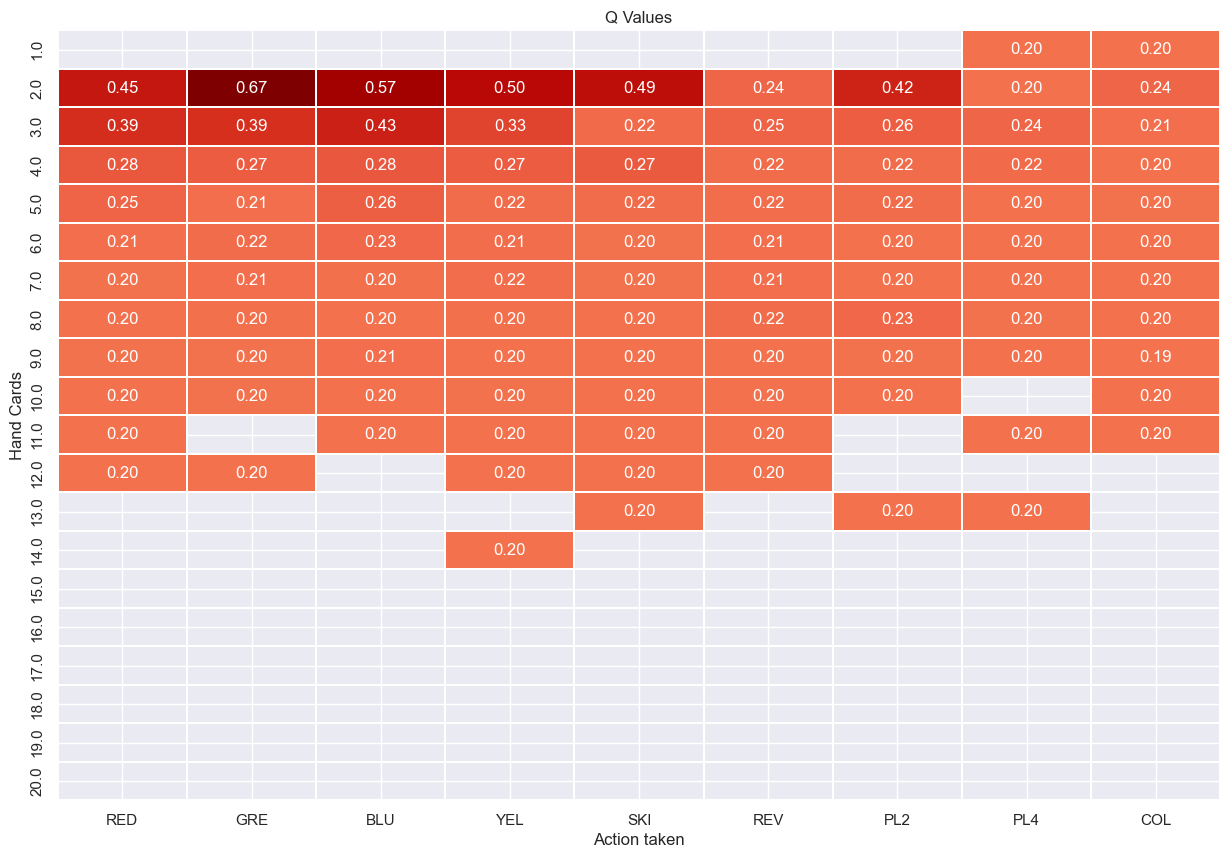

In [16]:
q_pivot = q_values.replace(0, np.NaN)
q_pivot = q_pivot.drop(columns='MAX').groupby("HAND").mean()

# Plotting
fig, ax = plt.subplots(1, 1, figsize = (15,10))

sns.heatmap(q_pivot, 
            fmt=".2f", 
            cmap = "OrRd", 
            linewidth = 0.3, 
            annot = True,
            cbar = False,
            center = 0.1)

ax.title.set_text("Q Values")
ax.set(xlabel="Action taken", ylabel="Hand Cards")
plt.show()